In [3]:
#%%
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm

# import pymc as pm
import aesara.tensor as at 
import aesara


In [15]:
#%%
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
#%%
N=250
mu_A, std_A = 30,4
mu_B, std_B = 35,7

# %%
duration_A = np.random.normal(mu_A,std_A,size=N)
duration_B = np.random.normal(mu_B,std_B,size=N)

# %%
print (duration_B[:8])


[30.85237346 28.05568968 44.2077682  25.48412944 26.02619557 36.2976398
 39.70826617 45.94934155]


In [16]:

# %%
pooled_mean = np.r_[duration_A,duration_B].mean()
pooled_std = np.r_[duration_A,duration_B].std()
tau = 1/(1000*pooled_std**2) # precision parameter
# %%



In [17]:
with pm.Model() as model:
    mu_A = pm.Normal("mu_A",mu=pooled_mean,sigma=10*pooled_std)
    mu_B = pm.Normal("mu_B",mu=pooled_mean,sigma=10*pooled_std)

    std_A = pm.Uniform("std_A", pooled_std/1000, 1000*pooled_std)
    std_B = pm.Uniform("std_B", pooled_std/1000, 1000*pooled_std)

    nu = pm.Exponential("nu-1",1/29)+1

    lambda_A = std_A**-2
    lambda_B = std_B**-2

    obs_A = pm.StudentT("obs_A",mu=mu_A,lam=lambda_A, nu=nu, observed=duration_A)
    obs_B = pm.StudentT("obs_B",mu=mu_B,lam=lambda_B, nu=nu, observed=duration_B)

    # If you want to get MCMC samples of some transformations of parameters, 
    # pm.use Deterministic
    diff_of_means = pm.Deterministic('difference of means', mu_A - mu_B)
    diff_of_stds = pm.Deterministic('difference of stds', std_A - std_B)
    effect_size = pm.Deterministic('effect size',diff_of_means / np.sqrt((std_A**2 + std_B**2) / 2))


In [12]:
with model:
    race = pm.sample(25000, tune=10000, return_inferencedata=True)
    # trace = pm.sample(2000, chains=4, tune=1000)
    # step = pm.Metropolis()
    
    # trace = pm.sample(20000, step=step,chains=2)
    # trace = pm.sample(iter=25000,tune=1000,step=step, thin=1,cores=1) # Broken pipe

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_A, mu_B, std_A, std_B, nu-1]


Sampling 4 chains for 10_000 tune and 25_000 draw iterations (40_000 + 100_000 draws total) took 25 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


Multiprocess sampling (2 chains in 4 jobs)
CompoundStep
>Metropolis: [mu_A]
>Metropolis: [mu_B]
>Metropolis: [std_A]
>Metropolis: [std_B]
>Metropolis: [nu-1]


Sampling 2 chains for 10_000 tune and 20_000 draw iterations (20_000 + 40_000 draws total) took 11 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


A평균:30.134, B평균:35.033, A-B평균:-4.898


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_A,30.134,0.257,29.636,30.605,0.003,0.002,8118.0,8473.0,1.0
mu_B,35.033,0.444,34.190,35.847,0.005,0.003,8822.0,9056.0,1.0
std_A,3.942,0.199,3.563,4.304,0.003,0.002,5980.0,6867.0,1.0
std_B,6.824,0.329,6.228,7.463,0.004,0.003,6512.0,7855.0,1.0
nu-1,44.372,28.716,8.488,98.809,0.357,0.253,5833.0,7142.0,1.0
difference of means,-4.898,0.513,-5.865,-3.932,0.005,0.004,8959.0,10576.0,1.0
difference of stds,-2.882,0.368,-3.571,-2.196,0.004,0.003,7432.0,9468.0,1.0
effect size,-0.880,0.099,-1.075,-0.699,0.001,0.001,8149.0,11586.0,1.0


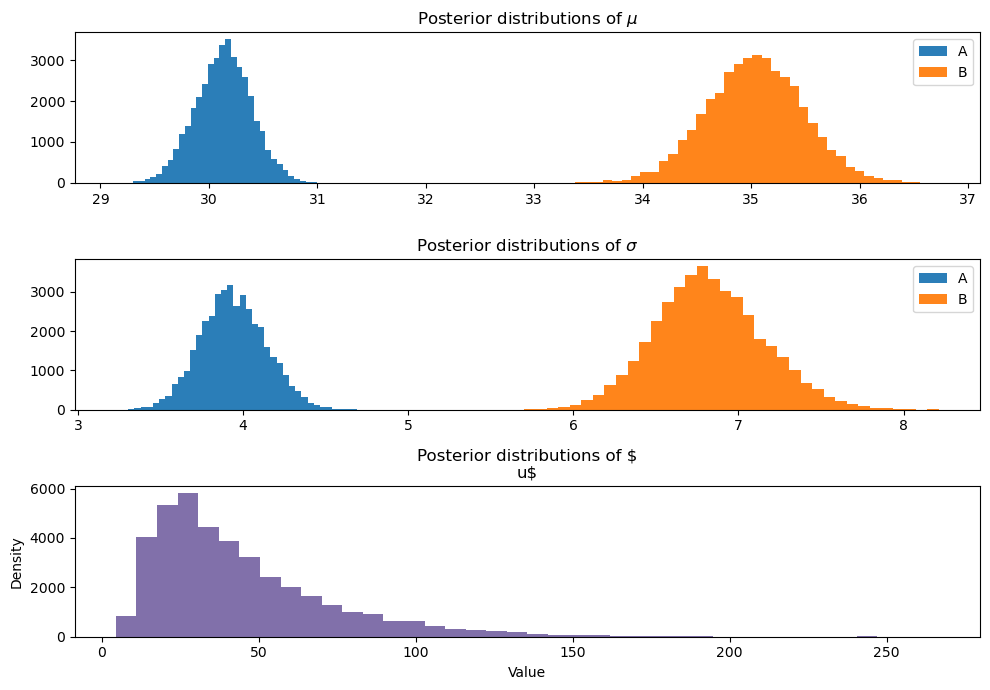

In [18]:
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

# PyMC v4에서 MCMC 샘플링을 진행하는 코드
with model:
    trace = pm.sample(20000, tune=10000, chains=2, step=pm.Metropolis(), return_inferencedata=True)

# 추적 객체에서 파라미터의 흔적을 추출
mu_A_trace = trace.posterior["mu_A"].values.flatten()
mu_B_trace = trace.posterior["mu_B"].values.flatten()
std_A_trace = trace.posterior["std_A"].values.flatten()
std_B_trace = trace.posterior["std_B"].values.flatten()
nu_trace = trace.posterior["nu-1"].values.flatten()  # 'nu-1'이 'nu'로 변경되었는지 확인하세요.


# 시각화
def _hist(data, label, **kwargs):
    return plt.hist(data, bins=40, histtype="stepfilled", alpha=.95, label=label, **kwargs)

# Posterior distributions plotting
plt.figure(figsize=[10, 7])  # 조정해야 할 수도 있습니다.
ax = plt.subplot(3, 1, 1)
_hist(mu_A_trace, "A")
_hist(mu_B_trace, "B")
plt.legend()
plt.title("Posterior distributions of $\mu$")

ax = plt.subplot(3, 1, 2)
_hist(std_A_trace, "A")
_hist(std_B_trace, "B")
plt.legend()
plt.title("Posterior distributions of $\sigma$")

ax = plt.subplot(3, 1, 3)
_hist(nu_trace, "", color="#7A68A6")
plt.title("Posterior distributions of $\nu$")
plt.xlabel("Value")
plt.ylabel("Density")
plt.tight_layout()

# 차이 출력
print(f"A평균:{mu_A_trace.mean():.3f}, B평균:{mu_B_trace.mean():.3f}, A-B평균:{(mu_A_trace - mu_B_trace).mean():.3f}")

# Summary and diagnostics
az.summary(trace)


In [8]:

mcmc = pm.MCMC([obs_A,obs_B,mu_A,mu_B,std_A,std_B,nu_m1])
mcmc.sample(25000,10000)

# %%
mu_A_trace = mcmc.trace("mu_A")[:]
mu_B_trace = mcmc.trace("mu_B")[:]
std_A_trace = mcmc.trace("std_A")[:]
std_B_trace = mcmc.trace("std_B")[:] #[:]: trace object => ndarray
nu_trace    = mcmc.trace("nu-1")[:]+1

# %%
def _hist(data,label,**kwargs):
    return plt.hist(data,bins=40,histtype="stepfilled",alpha=.95,label=label, **kwargs)

ax = plt.subplot(3,1,1)
_hist(mu_A_trace,"A")
_hist(mu_B_trace,"B")
plt.legend ()
plt.title("Posterior distributions of $\mu$")

ax=plt.subplot (3,1,2)
_hist(std_A_trace,"A")
_hist(std_B_trace,"B")
plt.legend ()
plt.title("Posterior distributions of $\sigma$")

ax=plt.subplot (3,1,3)
_hist(nu_trace,"",color="#7A68A6")
plt.title(r"Posterior distributions of $\nu$")
plt.xlabel("Value")
plt.ylabel("Density")
plt.tight_layout()
# plt.savefig("../assaeunji.github.io/images/abtest-duration.png")

# %%
# Difference
print("A평균:{:.3f}, B평균:{:.3f}, A-B평균:{:.3f}".format(mu_A_trace.mean(), mu_B_trace.mean(), (mu_A_trace-mu_B_trace).mean()))

# %%
pm.Matplot.plot(mcmc)
mcmc.summary()

AttributeError: module 'pymc' has no attribute 'MCMC'